In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd

In [14]:
#if i want to include SMA/stock data for same company, need to scrape function not just symbol
def TimeSeriesDaily_df(stock_name):
    """
    Read a CSV file from a URL and return a DataFrame with symbol as the last column.
    """
    url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_name}&outputsize=full&apikey=98WO4EK4CGOBTPQR&datatype=csv'
    df = pd.read_csv(url)
    df['symbol'] = stock_name
    return df
    

In [15]:
def get_close_prices(portfolio):
    """
    Returns a DataFrame of close prices for the given portfolio.
    """
    data = {}
    for s in portfolio:
        df = TimeSeriesDaily_df(s)
        prices = np.array(df['close'])[::-1]
        data[s] = prices
    df = pd.DataFrame(data)
    df['mean'] = df.mean(axis=1)
    data_arr = df.to_numpy()
    return data_arr.T

In [16]:
def predict_price(M1, M2, l):
    ''' 
    Uses Koopman related DMD algorithm to predict future prices.
    l is the number of days in the future to predict
    ''' 
    U, s, Vt = np.linalg.svd(M1, full_matrices=False)
    Sigma_inv = np.diag(1.0/s)
    A_tilde = U.T @ M2 @ Vt.T @ Sigma_inv
    evals, evecs = np.linalg.eig(A_tilde)
    Phi = U @ evecs
    x0 = M1[:, 0].reshape((-1,1))
    b = np.linalg.pinv(Phi) @ x0

    n, r = Phi.shape
    preds = np.zeros((n, l))
    for t in range(1, l+1):
        D = np.diag(np.exp(np.log(evals) * t))
        x_t = Phi @ D @ b
        preds[:, t-1] = x_t.ravel().real
    
    return preds

In [17]:
def directional_accuracy(prediction, actual):
    '''
    Returns the accuracy of the predictions. The model is accurate if
    the predicted direction of the price change matches the actual direction.
    '''
    if prediction.shape != actual.shape:
        raise ValueError("Prediction and actual arrays must have the same shape.")

    diff_pred = prediction[:, 1:] - prediction[:, :-1]  
    diff_act = actual[:, 1:] - actual[:, :-1]     
    
    correct = np.sum(diff_pred * diff_act > 0)
    return correct/diff_pred.size
    

In [28]:
home_construction_portfolio = ['DHI', 'LEN', 'PHM', 'TOL', 'NVR', 'HD', 'LOW', 'SHW', 'SPY']
home_construction_data = get_close_prices(home_construction_portfolio)

In [29]:
def find_hotspot(data_arr):
    ''' 
    Finds potential hotspots based on the directional accuracy of price predictions. 
    Uses past 100 days of data to run through a range of parameters (m, l) to find
    combinations that yield an accuracy greater than 0.53.

    Returns a list of tuples (m, l, accuracy) for all combinations tested.
    '''
    accuracy_scores = []
    potential_hotspots = []

    for m in range(4, 15):
        for l in range(2, 10):
            scores = []
            for t in range(m, len(data_arr)-l): 
                M = data_arr[:, t-m:t]
                M1 = M[:, :-1]
                M2 = M[:, 1:]
                preds = predict_price(M1, M2, l)[: -1, :] #drop the mean column
                actual = data_arr[:, t:t+l][: -1, :]
                scores.append(directional_accuracy(preds, actual))
            accuracy = np.sum(scores) / len(scores)
            accuracy_scores.append((m, l, accuracy))
            if accuracy > 0.53: #arbitrary threshold
                potential_hotspots.append((m, l, accuracy))
    return accuracy_scores, potential_hotspots

I want to compare 2 strategies based on their P&L. 

- Strategy 1: split up 10 years of data into 100 day increments. Then find a hotspot using the first 100 days, invest l future days; recalibrate the hotspot after l days, and repeat on 10 years of data.
- Strategy 2: Find a hotspot over 2 years of data, then use that hotspot for the next 6 months or something. Then recalibrate.
- Strategy 3: Find a hotspot over 3 years, and use the same hotspot for the next 7 years.

Compare all these to the benchmark S&P 500.

In [30]:
def strategy_1(portfolio):
    '''
    Strategy 1: split up 10 years of data into 100 day increments.
    Then find a hotspot using the first 100 days, invest l future days; 
    recalibrate the hotspot after l days, and repeat on 10 years of data.
    '''
    hist_data_10_yrs = get_close_prices(portfolio)
    n = hist_data_10_yrs.shape[1]
    hist_data_10_yrs = hist_data_10_yrs[:, n//2:] # Use only the most recent 10 years of data

    delta = 0
    while delta < hist_data_10_yrs.shape[1]-100: #can adjust this 100 to change the number of days used to find hotspots
        data_arr = hist_data_10_yrs[:, delta:delta+100]
        accuracy_scores, potential_hotspots = find_hotspot(data_arr)
        if potential_hotspots:
            sorted_by_score = sorted(potential_hotspots, key=lambda tpl: tpl[2], reverse=True)
            #here we can build and call a function that checks if the average of its neighbors are also > 51% 
            #for now will just take the highest accuracy score and use the corresponding (m,l) as the hotspot
            m, l, accuracy = sorted_by_score[0]
            #build and call a function that invests and tracks P&L using (m,l) hotspot
            delta += l

In [31]:
accuracy_scores, potential_hotspots = find_hotspot(home_construction_data)

/var/folders/99/7dwb3s493wl3kpwfmxrz5nwc0000gn/T/ipykernel_11870/2942774990.py:17: RuntimeWarning: invalid value encountered in log
  D = np.diag(np.exp(np.log(evals) * t))
/var/folders/99/7dwb3s493wl3kpwfmxrz5nwc0000gn/T/ipykernel_11870/3160097449.py:22: RuntimeWarning: invalid value encountered in double_scalars
  accuracy = np.sum(scores) / len(scores)


In [32]:
potential_hotspots

[(5, 4, 0.5555555555555556),
 (6, 2, 0.5555555555555556),
 (6, 3, 0.5555555555555556),
 (7, 2, 0.5555555555555556)]

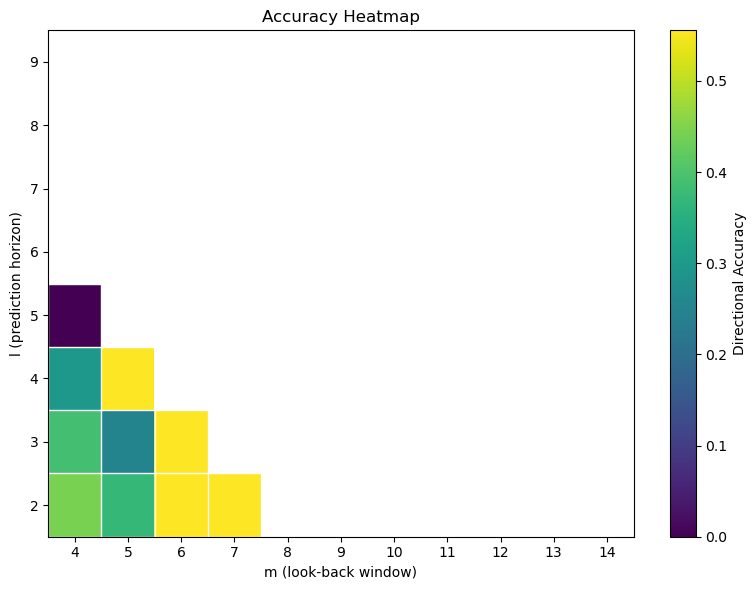

In [33]:

ms = sorted({m for m, l, score in accuracy_scores})
ls = sorted({l for m, l, score in accuracy_scores})

heatmap = np.zeros((len(ls), len(ms)))

for (m_val, l_val, score) in accuracy_scores:
    i = ls.index(l_val)   
    j = ms.index(m_val) 
    heatmap[i, j] = score

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(heatmap, origin='lower', aspect='auto')

ax.set_xticks(np.arange(len(ms)))
ax.set_xticklabels(ms)
ax.set_yticks(np.arange(len(ls)))
ax.set_yticklabels(ls)

ax.set_xticks(np.arange(len(ms) + 1) - 0.5, minor=True)
ax.set_yticks(np.arange(len(ls) + 1) - 0.5, minor=True)

ax.grid(which='minor', color='white', linestyle='-', linewidth=1)

ax.tick_params(which='minor', bottom=False, left=False)

ax.set_xlabel('m (look-back window)')
ax.set_ylabel('l (prediction horizon)')
ax.set_title('Accuracy Heatmap')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Directional Accuracy')

plt.tight_layout()
plt.show()